In [ ]:
!pip install mysql-connector-python tabulate sqlalchemy pymysql

In [ ]:
import pandas as pd; import mysql.connector, json
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sqlalchemy import create_engine; from tabulate import tabulate

In [ ]:
mydb=mysql.connector.connect(
    host="localhost",
    username="root",
    password="",
    port=3306)
mycursor=mydb.cursor(buffered=True)

In [ ]:
mycursor.execute("CREATE DATABASE project2")

In [ ]:
mycursor.execute("USE project2")

In [ ]:
username = 'root'
password = 'your_password'
host = 'localhost'
port = 3306
database = 'project2'
engine = create_engine('mysql+pymysql://root@localhost/project2')

In [39]:
file_path = r"D:\MyProjectsDuplicates\project2\Bird_Monitoring_Data_GRASSLAND.XLSX" 
excel_data = pd.ExcelFile(file_path)  
sheet_names = excel_data.sheet_names 
sheets_dict = {sheet: excel_data.parse(sheet) for sheet in sheet_names} 

file_path1 = r"D:\MyProjectsDuplicates\project2\Bird_Monitoring_Data_FOREST.XLSX" 
excel_data1 = pd.ExcelFile(file_path1)  
sheet_names1 = excel_data1.sheet_names 
sheets_dict1 = {sheet: excel_data1.parse(sheet) for sheet in sheet_names1}

In [40]:
combined_df = pd.concat(
    [df.assign(Sheet=sheet_name) for sheet_name, df in sheets_dict.items()],
    ignore_index=True)
df1 = combined_df.drop(columns=['Sheet'])

C:\Users\USER\AppData\Local\Temp\ipykernel_20768\2383316230.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(


In [41]:
combined_df1 = pd.concat(
    [df.assign(Sheet=sheet_name) for sheet_name, df in sheets_dict1.items()],
    ignore_index=True)
df2 = combined_df1.drop(columns=['Sheet'])

In [42]:
cols_df1 = set(df1.columns)
cols_df2 = set(df2.columns)
diff_cols_df1 = cols_df1 - cols_df2
diff_cols_df2 = cols_df2 - cols_df1
print("Columns in df1 but not in df2:", diff_cols_df1)
print("Columns in df2 but not in df1:", diff_cols_df2)
df1= df1.rename(columns={'TaxonCode': 'NPSTaxonCode'})

Columns in df1 but not in df2: {'Previously_Obs', 'TaxonCode'}
Columns in df2 but not in df1: {'Site_Name', 'NPSTaxonCode'}


In [43]:
combined_df = pd.concat([df1, df2], ignore_index=True)
combined_df.index = range(1, len(combined_df) + 1)

In [44]:
combined_df.drop('Sub_Unit_Code', axis=1, inplace=True)
combined_df.loc[combined_df['Common_Name'] == 'Northwestern Crow', 'NPSTaxonCode'] = 87106
combined_df.drop(combined_df[combined_df['Common_Name'] == 'Chinese Pond-Heron'].index, inplace=True)
combined_df.loc[combined_df['Common_Name'] == 'House Finch', 'AcceptedTSN'] = 997805

In [45]:
combined_df['Start_Time'] = pd.to_datetime(combined_df['Start_Time'], format='%H:%M:%S').dt.time
combined_df['End_Time'] = pd.to_datetime(combined_df['End_Time'], format='%H:%M:%S').dt.time

In [46]:
combined_df["Initial_Three_Min_Cnt"]=combined_df["Initial_Three_Min_Cnt"].astype(bool)
combined_df["Previously_Obs"]=combined_df["Previously_Obs"].astype(object)
combined_df["PIF_Watchlist_Status"]=combined_df["PIF_Watchlist_Status"].astype(bool)
combined_df["Regional_Stewardship_Status"]=combined_df["Regional_Stewardship_Status"].astype(bool)
combined_df["Flyover_Observed"]=combined_df["Flyover_Observed"].astype(bool)

In [47]:
duplicates = combined_df.duplicated()
duplicates = combined_df[combined_df.duplicated(keep='first')]
combined_df = combined_df.drop_duplicates(keep='first')

In [48]:
combined_df.loc[:, 'ID_Method'] = combined_df['ID_Method'].fillna(combined_df['ID_Method'].mode()[0])
combined_df.loc[:, 'Distance'] = combined_df['Distance'].fillna('> 50 Meters')

In [49]:
combined_df.loc[:, 'Month'] = combined_df['Date'].dt.month
month_al= {5: 'May', 6: 'June', 7: 'July'}
combined_df['Month'] = combined_df['Month'].replace(month_al)

In [50]:
def get_season(month):
    if month in [5]:
        return 'Spring'
    else:
        return 'Summer'
combined_df['Season'] = combined_df['Date'].dt.month.apply(get_season)

In [51]:

combined_df['Start_Time'] = pd.to_datetime(combined_df['Start_Time'], format='%H:%M:%S')
combined_df['End_Time'] = pd.to_datetime(combined_df['End_Time'], format='%H:%M:%S')
combined_df['Observation_Duration'] = combined_df['End_Time'] - combined_df['Start_Time']
def format_to_hr_min(td):
    total_minutes = int(td.total_seconds() // 60)
    h, m = divmod(total_minutes, 60)
    parts = []
    if h > 0:
        parts.append(f"{h} hr")
    if m > 0:
        parts.append(f"{m} min")
    return ' '.join(parts) if parts else "0 min"
combined_df['Observation_Duration'] = combined_df['Observation_Duration'].apply(format_to_hr_min)

In [52]:
combined_df = combined_df.drop(columns=['Date', 'Previously_Obs', 'Site_Name'])
combined_df['Sex'] = combined_df['Sex'].fillna('Unknown')

<Axes: ylabel='Humidity'>

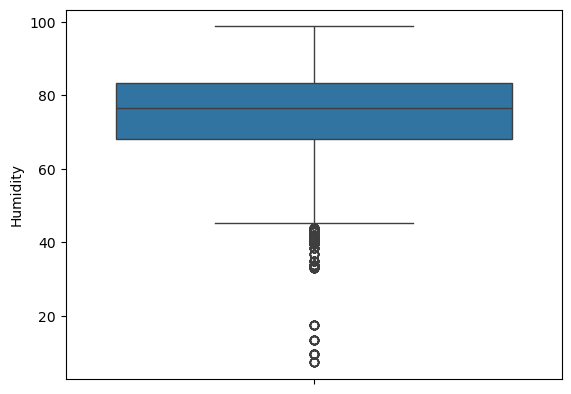

In [53]:
sns.boxplot(combined_df["Humidity"])

In [54]:
Q1 = combined_df["Humidity"].quantile(0.25)
Q3 = combined_df["Humidity"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = combined_df[(combined_df["Humidity"] < lower_bound) | (combined_df["Humidity"] > upper_bound)]
combined_df.loc[combined_df['Humidity'] > upper_bound, 'Humidity'] = upper_bound
combined_df.loc[combined_df['Humidity'] < lower_bound, 'Humidity'] = lower_bound
outliers = combined_df[(combined_df["Humidity"] < lower_bound) | (combined_df["Humidity"] > upper_bound)]
print(f"Remaining outliers: {len(outliers)}")

Remaining outliers: 0


<Axes: ylabel='Temperature'>

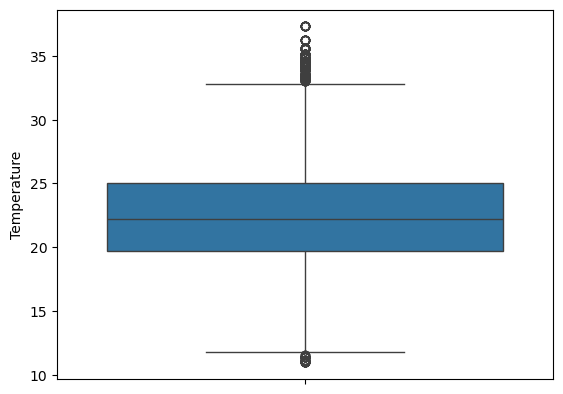

In [55]:
sns.boxplot(combined_df["Temperature"])

In [56]:
Q1 = combined_df["Temperature"].quantile(0.25)
Q3 = combined_df["Temperature"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = combined_df[(combined_df["Temperature"] < lower_bound) | (combined_df["Temperature"] > upper_bound)]
combined_df.loc[combined_df['Temperature'] > upper_bound, 'Temperature'] = upper_bound
combined_df.loc[combined_df['Temperature'] < lower_bound, 'Temperature'] = lower_bound
outliers = combined_df[(combined_df["Temperature"] < lower_bound) | (combined_df["Temperature"] > upper_bound)]
print(f"Remaining outliers: {len(outliers)}")

Remaining outliers: 0



What type of data would you like to visualize?
1. Categorical
2. Discrete
3. Continuous
4. Date/Time


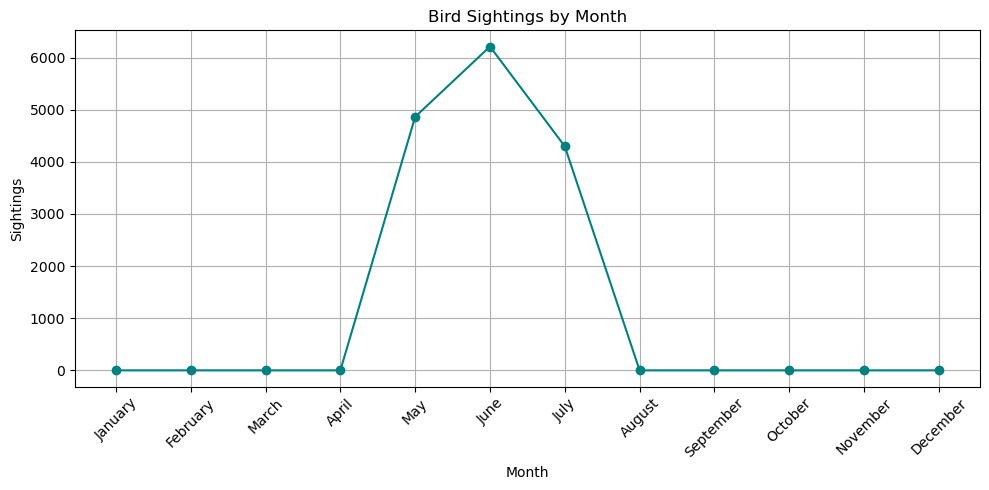

In [120]:
categorical_cols = [
    'Admin_Unit_Code', 'Plot_Name', 'Location_Type', 'Observer', 'Interval_Length',
    'ID_Method', 'Distance', 'Flyover_Observed', 'Sex', 'Common_Name', 'Scientific_Name',
    'AOU_Code', 'PIF_Watchlist_Status', 'Regional_Stewardship_Status',
    'Sky', 'Wind', 'Disturbance', 'Previously_Obs', 'Initial_Three_Min_Cnt', 'Site_Name',
    'Season'
]
discrete_cols = ['Year', 'Visit']
continuous_cols = ['Temperature', 'Humidity']
datetime_cols = ['Month']


def choose_column(col_list):
    print("\nAvailable columns:")
    for idx, col in enumerate(col_list, start=1):
        print(f"{idx}. {col}")
    try:
        col_index = int(input("Select a column number: ")) - 1
        if 0 <= col_index < len(col_list):
            return col_list[col_index]
        else:
            print("Error: Invalid selection, number out of range.")
            return None
    except ValueError:
        print("Error: Invalid input. Please enter a valid number.")
        return None


print("\nWhat type of data would you like to visualize?")
print("1. Categorical")
print("2. Discrete")
print("3. Continuous")
print("4. Date/Time")
choice = input("Enter your choice (1–4): ")


if choice == "1":
    selected_col = choose_column(categorical_cols)
    if selected_col and selected_col in combined_df.columns:
        value_counts = combined_df[selected_col].value_counts().head(20)
        plt.figure(figsize=(10, 5))
        plt.barh(value_counts.index[::-1], value_counts.values[::-1], color='skyblue')
        plt.title(f"Top 20 values in '{selected_col}'")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Error: '{selected_col}' not found in the dataset.")


elif choice == "2":
    selected_col = choose_column(discrete_cols)
    if selected_col and selected_col in combined_df.columns:
        counts = combined_df[selected_col].value_counts().sort_index()
        plt.figure(figsize=(6, 4))
        plt.bar(counts.index, counts.values, color='lightgreen')
        plt.title(f"Distribution of '{selected_col}'")
        plt.xlabel(selected_col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Error: '{selected_col}' not found in the dataset.")


elif choice == "3":
    selected_col = choose_column(continuous_cols)
    if selected_col and selected_col in combined_df.columns:
        plt.figure(figsize=(6, 4))
        plt.hist(combined_df[selected_col].dropna(), bins=20, color='coral', edgecolor='black')
        plt.title(f"Histogram of '{selected_col}'")
        plt.xlabel(selected_col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Error: '{selected_col}' not found in the dataset.")


elif choice == "4":
    if 'Month' in combined_df.columns:
       
        month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                       'July', 'August', 'September', 'October', 'November', 'December']

      
        combined_df['Month'] = pd.Categorical(combined_df['Month'], categories=month_order, ordered=True)
        month_counts = combined_df['Month'].value_counts().sort_index()

        plt.figure(figsize=(10, 5))
        plt.plot(month_counts.index, month_counts.values, marker='o', linestyle='-', color='teal')
        plt.xticks(rotation=45)
        plt.title("Bird Sightings by Month")
        plt.xlabel("Month")
        plt.ylabel("Sightings")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Error: 'Month' column not found in the dataset.")


else:
    print("Error: Invalid choice. Please select a number from 1 to 4.")


In [75]:
combined_df.isnull().sum()

Admin_Unit_Code                0
Plot_Name                      0
Location_Type                  0
Year                           0
Start_Time                     0
End_Time                       0
Observer                       0
Visit                          0
Interval_Length                0
ID_Method                      0
Distance                       0
Flyover_Observed               0
Sex                            0
Common_Name                    0
Scientific_Name                0
AcceptedTSN                    0
NPSTaxonCode                   0
AOU_Code                       0
PIF_Watchlist_Status           0
Regional_Stewardship_Status    0
Temperature                    0
Humidity                       0
Sky                            0
Wind                           0
Disturbance                    0
Initial_Three_Min_Cnt          0
Month                          0
Season                         0
Observation_Duration           0
Latitude                       0
Longitude 

In [59]:
combined_df.dtypes

Admin_Unit_Code                        object
Plot_Name                              object
Location_Type                          object
Year                                   object
Start_Time                     datetime64[ns]
End_Time                       datetime64[ns]
Observer                               object
Visit                                  object
Interval_Length                        object
ID_Method                              object
Distance                               object
Flyover_Observed                         bool
Sex                                    object
Common_Name                            object
Scientific_Name                        object
AcceptedTSN                           float64
NPSTaxonCode                          float64
AOU_Code                               object
PIF_Watchlist_Status                     bool
Regional_Stewardship_Status              bool
Temperature                           float64
Humidity                          

In [60]:
location_map = {
    'ANTI': ('39.4671°N', '77.7363°W'),
    'CATO': ('39.6268°N', '77.4398°W'),
    'CHOH': ('39.5000°N', '77.8450°W'),
    'GWMP': ('38.9601°N', '77.1517°W'),
    'HAFE': ('39.3178°N', '77.7581°W'),
    'MANA': ('38.8171°N', '77.5353°W'),
    'MONO': ('39.3775°N', '77.3973°W'),
    'NACE': ('38.8660°N', '76.9940°W'),
    'PRWI': ('38.5854°N', '77.3842°W'),
    'ROCR': ('38.9675°N', '77.0452°W'),
    'WOTR': ('38.933477°N', '-77.276510°W')}
combined_df['Latitude'] = None
combined_df['Longitude'] = None

for code, (lat, lon) in location_map.items():
    combined_df.loc[combined_df['Admin_Unit_Code'] == code, ['Latitude', 'Longitude']] = [lat, lon]

In [61]:
def clean_lat(lat_str):
    if isinstance(lat_str, str):
        return float(lat_str.replace("°N", "").replace("° N", "").strip())
    return lat_str 

def clean_long(long_str):
    if isinstance(long_str, str):
        long_str = long_str.replace("°W", "").replace("° W", "").replace("−", "-").strip()
        return -abs(float(long_str)) 
    return long_str 

In [62]:
combined_df["Latitude"] = combined_df["Latitude"].apply(clean_lat)
combined_df["Longitude"] = combined_df["Longitude"].apply(clean_long)
combined_df

,Admin_Unit_Code,Plot_Name,Location_Type,Year,Start_Time,End_Time,Observer,Visit,Interval_Length,ID_Method,...,Humidity,Sky,Wind,Disturbance,Initial_Three_Min_Cnt,Month,Season,Observation_Duration,Latitude,Longitude
1,ANTI,ANTI-0054,Grassland,2018,1900-01-01 05:35:00,1900-01-01 05:45:00,Elizabeth Oswald,1,0-2.5 min,Singing,...,79.0,Cloudy/Overcast,Light breeze (4-7 mph) wind felt on face,Slight effect on count,True,May,Spring,10 min,39.467100,-77.73630
2,ANTI,ANTI-0054,Grassland,2018,1900-01-01 05:35:00,1900-01-01 05:45:00,Elizabeth Oswald,1,7.5 - 10 min,Singing,...,79.0,Cloudy/Overcast,Light breeze (4-7 mph) wind felt on face,Slight effect on count,False,May,Spring,10 min,39.467100,-77.73630
3,ANTI,ANTI-0054,Grassland,2018,1900-01-01 05:35:00,1900-01-01 05:45:00,Elizabeth Oswald,1,0-2.5 min,Singing,...,79.0,Cloudy/Overcast,Light breeze (4-7 mph) wind felt on face,Slight effect on count,True,May,Spring,10 min,39.467100,-77.73630
4,ANTI,ANTI-0054,Grassland,2018,1900-01-01 05:35:00,1900-01-01 05:45:00,Elizabeth Oswald,1,0-2.5 min,Singing,...,79.0,Cloudy/Overcast,Light breeze (4-7 mph) wind felt on face,Slight effect on count,True,May,Spring,10 min,39.467100,-77.73630
5,ANTI,ANTI-0054,Grassland,2018,1900-01-01 05:35:00,1900-01-01 05:45:00,Elizabeth Oswald,1,0-2.5 min,Singing,...,79.0,Cloudy/Overcast,Light breeze (4-7 mph) wind felt on face,Slight effect on count,True,May,Spring,10 min,39.467100,-77.73630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17073,WOTR,WOTR-0001,Forest,2018,1900-01-01 08:13:00,1900-01-01 08:23:00,Kimberly Serno,2,0-2.5 min,Singing,...,75.5,Clear or Few Clouds,Light air movement (1-3 mph) smoke drifts,Slight effect on count,True,July,Summer,10 min,38.933477,-77.27651
17074,WOTR,WOTR-0001,Forest,2018,1900-01-01 08:13:00,1900-01-01 08:23:00,Kimberly Serno,2,0-2.5 min,Singing,...,75.5,Clear or Few Clouds,Light air movement (1-3 mph) smoke drifts,Slight effect on count,True,July,Summer,10 min,38.933477,-77.27651
17075,WOTR,WOTR-0001,Forest,2018,1900-01-01 08:13:00,1900-01-01 08:23:00,Kimberly Serno,2,7.5 - 10 min,Singing,...,75.5,Clear or Few Clouds,Light air movement (1-3 mph) smoke drifts,Slight effect on count,False,July,Summer,10 min,38.933477,-77.27651
17076,WOTR,WOTR-0001,Forest,2018,1900-01-01 08:13:00,1900-01-01 08:23:00,Kimberly Serno,2,0-2.5 min,Singing,...,75.5,Clear or Few Clouds,Light air movement (1-3 mph) smoke drifts,Slight effect on count,True,July,Summer,10 min,38.933477,-77.27651


In [74]:
combined_df.to_sql(name='birds_table', con=engine, if_exists='replace', index=False)

15371